<a href="https://colab.research.google.com/github/Zaka123456/MRP/blob/main/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.8 MB/s eta 0:00:00


In [ ]:
# Reinstall packages to resolve potential conflicts
#!pip uninstall -y numpy pmdarima scikit-learn scipy statsmodels
#!pip install numpy pmdarima scikit-learn scipy statsmodels

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import time

In [ ]:
# Import the necessary modules
import math
import random
import matplotlib.pyplot as plt
from scipy import stats
import sys
import os
import numpy as np
import seaborn as sns
#from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX


#  Feature Selection

from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, chi2, RFE

#  Preprocessing

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer




#  Model Evaluation

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit, RepeatedKFold
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,
    r2_score, classification_report, confusion_matrix
)

# Time Series Utilities
from pandas.tseries.offsets import DateOffset
import datetime

#Load Dataset

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/MRP/Current/Deliverables/Methodology_&_Experiments/Report/Coding/Data_files/Final_Selected_Features_new.csv', encoding='latin-1')

Best ARIMA order: (0, 1, 2)

Forecast Evaluation Metrics:
MAE   : 21344.75
RMSE  : 26687.65
sMAPE : 14.88%
R²    : -0.001


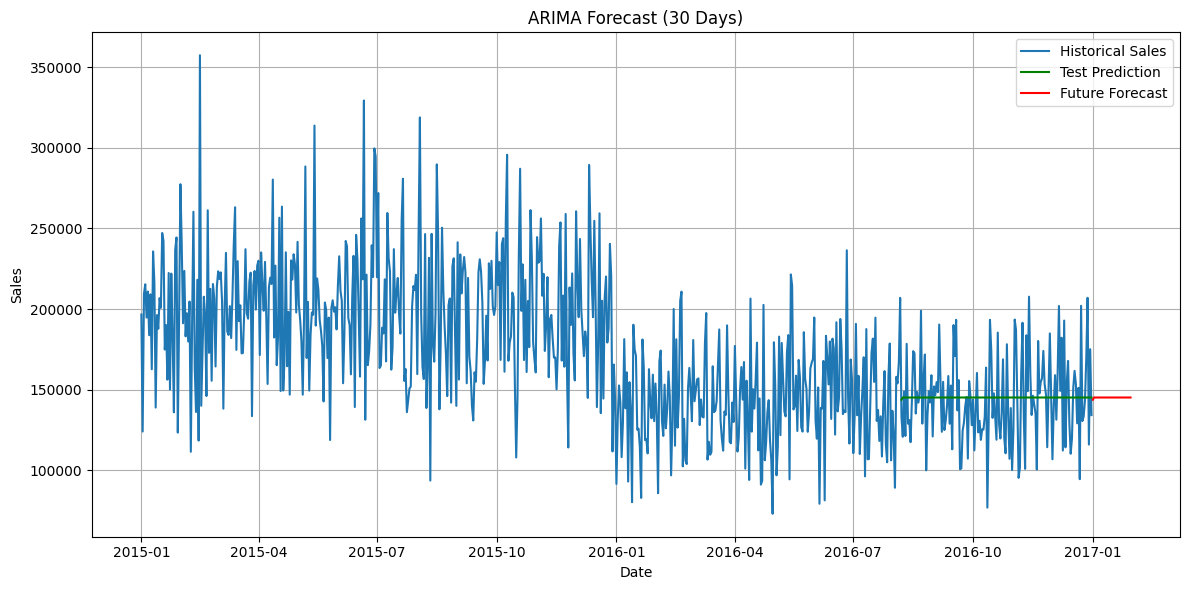

In [ ]:
# === ARIMA Forecast Script for Google Colab ===

# Install required packages
#!pip install -q pmdarima

# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os

warnings.filterwarnings("ignore")

# === Load and Aggregate Dataset ===
file_path = "/content/drive/MyDrive/MRP/Current/Deliverables/Methodology_&_Experiments/Report/Coding/Data_files/Final_Selected_Features_new.csv"
df = pd.read_csv(file_path, parse_dates=["date_only"])
df = df.sort_values("date_only")

# Ensure daily sales aggregation
series = df.groupby("date_only")["Sales"].sum().asfreq("D").fillna(0)

# === Train-Test Split ===
test_ratio = 0.2
split_idx = int(len(series) * (1 - test_ratio))
train, test = series[:split_idx], series[split_idx:]

# === Model Selection ===
def auto_model_fit(series, seasonal=False, sp=7, p_range=(0, 3), d_range=(0, 2), q_range=(0, 3)):
    best_aic = float("inf")
    best_model, best_order, best_seasonal_order = None, None, None

    pdq = list(itertools.product(range(*p_range), range(*d_range), range(*q_range)))
    seasonal_pdq = [(p, d, q, sp) for p, d, q in pdq] if seasonal else [(0, 0, 0, 0)]

    for order in pdq:
        for seasonal_order in seasonal_pdq:
            try:
                model = SARIMAX(series,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit(disp=False)
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_model = model
                    best_order = order
                    best_seasonal_order = seasonal_order if seasonal else None
            except:
                continue
    return best_model, best_order, best_seasonal_order

# === Fit ARIMA ===
seasonal = False
model, order, seasonal_order = auto_model_fit(train, seasonal=seasonal)

print(f"Best ARIMA order: {order}")
if seasonal:
    print(f"Seasonal order: {seasonal_order}")

# === Forecast Evaluation ===
pred_test = model.get_forecast(steps=len(test)).predicted_mean

mae = mean_absolute_error(test, pred_test)
rmse = np.sqrt(mean_squared_error(test, pred_test))

def smape(actual, forecast):
    denominator = (np.abs(actual) + np.abs(forecast)) / 2
    diff = np.abs(actual - forecast)
    return np.mean(np.where(denominator == 0, 0, diff / denominator)) * 100

s_mape = smape(test.values, pred_test.values)
r2 = r2_score(test, pred_test)

print(f"\nForecast Evaluation Metrics:")
print(f"MAE   : {mae:.2f}")
print(f"RMSE  : {rmse:.2f}")
print(f"sMAPE : {s_mape:.2f}%")
print(f"R²    : {r2:.3f}")

# === Forecast Future ===
horizon = 30
forecast = model.get_forecast(steps=horizon).predicted_mean
forecast_dates = pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=horizon, freq="D")
forecast_df = pd.DataFrame({"date": forecast_dates, "forecast_sales": forecast.values})

# Create the directory if it doesn't exist
output_dir = "/content/drive/MyDrive/MRP/Current/Deliverables/Methodology_&_Experiments/Report/Coding/Data_files/Models"
os.makedirs(output_dir, exist_ok=True)

forecast_df.to_csv(os.path.join(output_dir, "arima_forecast.csv"), index=False)

# === Save Plot ===
plt.figure(figsize=(12, 6))
plt.plot(series, label="Historical Sales")
plt.plot(test.index, pred_test, label="Test Prediction", color="green")
plt.plot(forecast_dates, forecast, label="Future Forecast", color="red")
plt.title("ARIMA Forecast (30 Days)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.legend()
plt.tight_layout()

plot_output_dir = "/content/drive/MyDrive/MRP/Current/Deliverables/Methodology_&_Experiments/Report/Coding/Data_files/Plots"
os.makedirs(plot_output_dir, exist_ok=True)
plt.savefig(os.path.join(plot_output_dir, "arima_forecast.png"))
plt.show()